# Time series: motif and shaplet

Motif: a repeated pattern in the time series.
We can discover motif by computing the Matrix Profile: a data structure that annotates time series by using a sliding window to compare the pairwise distance among the subsequences.

### Matrix Profile
You can use these packages:
    
    
https://github.com/target/matrixprofile-ts

https://github.com/TDAmeritrade/stumpy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import stumpy
from scipy.stats import zscore

In [2]:
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m')

# Read the CSV file with date parsing
df = pd.read_csv('./datasets/AirPassengers.csv', parse_dates=True, index_col='Month', date_parser=dateparse)

# Display the first few rows of the DataFrame
df.head()

/var/folders/bp/kpcs2z7s5_54t0p548zr3tb00000gn/T/ipykernel_17462/2280286134.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('./datasets/AirPassengers.csv', parse_dates=True, index_col='Month', date_parser=dateparse)


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


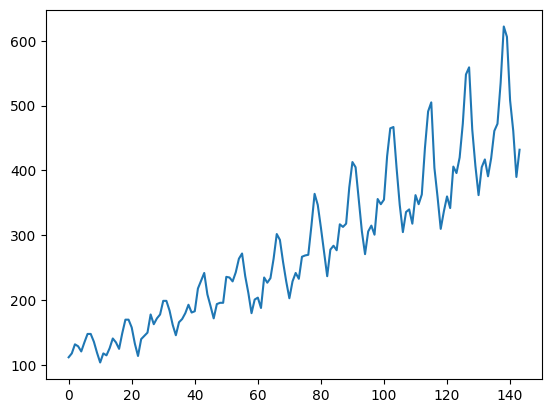

In [3]:
ts = df['#Passengers']
# Cast to float
ts = np.array(ts).astype(float)
plt.plot(ts)
plt.show()

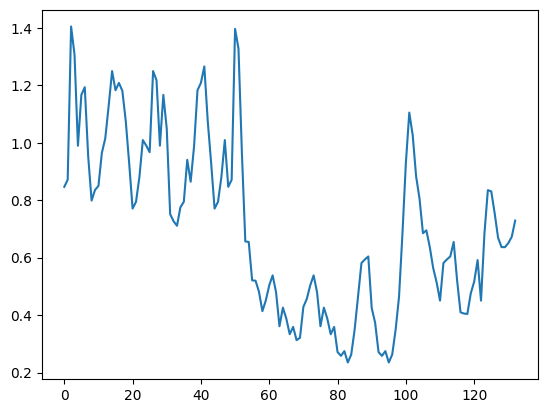

In [4]:
w = 12
mp = stumpy.stump(ts, m=w)[:, 0]

plt.plot(mp)
plt.show()

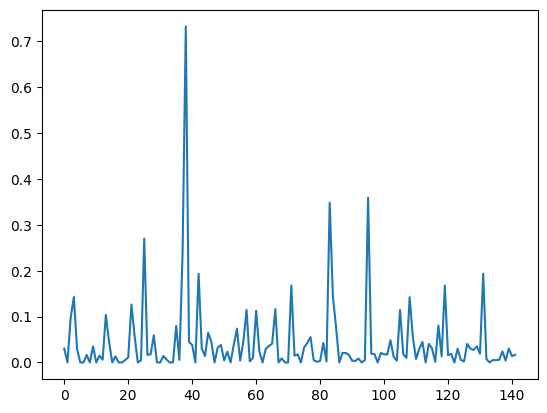

In [5]:
w = 3
mp = stumpy.stump(ts, w)[:, 0]

plt.plot(mp)
plt.show()

### Motif discovery
Parameters
- max_motifs: stop finding new motifs once we have max_motifs
- radius: For each motif found, find neighbors that are within radius*motif_mp of the first.
- n_neighbors: number of neighbors from the first to find. If it is None, find all.
- ex_zone: minimum distance between indices for after each subsequence is identified. Defaults to m/2 where m is the subsequence length. If ex_zone = 0, only the found index is exclude, if ex_zone = 1 then if idx is found as a motif idx-1, idx, idx+1 are excluded.


The function returns a tuple (top_motifs, distances) which are lists of the same length.

- top_motifs: This is a list of the indices found for each motif. The first index is the nth motif followed by all nearest neighbors found sorted by distances.
- distances: Minimum Matrix profile value for each motif set.

In [6]:
# Find the motifs and their locations
motif_dist, motif_idx = stumpy.motifs(ts, mp, max_motifs=5)

/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/stumpy/motifs.py:340: UserWarning: The `cutoff` has been set to 0.0 and may result in little/no candidate motifs being identified.
You may consider relaxing the constraint by increasing the `cutoff` (e.g., cutoff=0.0).
  warnings.warn(msg)


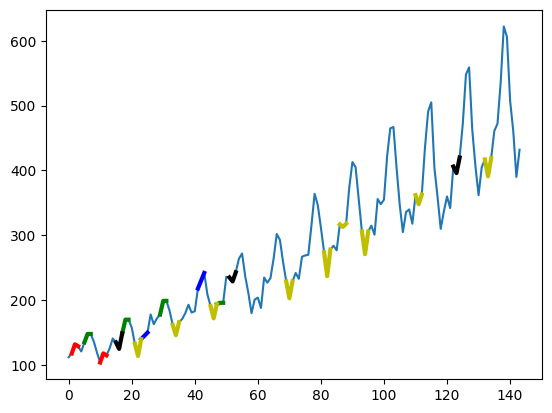

In [7]:
plt.plot(ts)

colors = ['r', 'g', 'k', 'b', 'y'][:len(motif_dist)]

for motifs, indices, color in zip(motif_dist, motif_idx, colors):
    for index in indices:
        motif_shape = ts[index:index + w]
        if len(motif_shape) == w:
            plt.plot(range(index, index + w), motif_shape, color=color, lw=3)

plt.show()

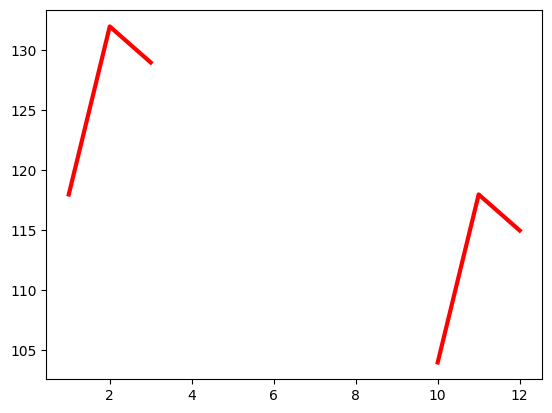

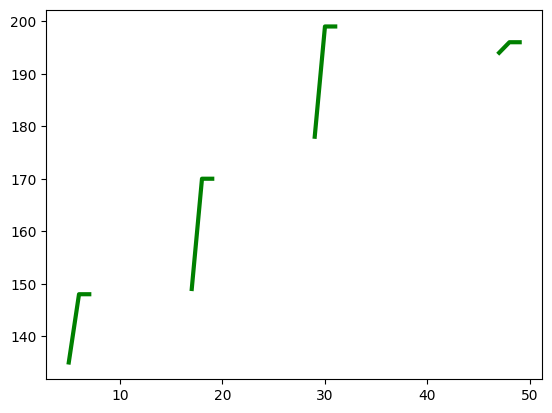

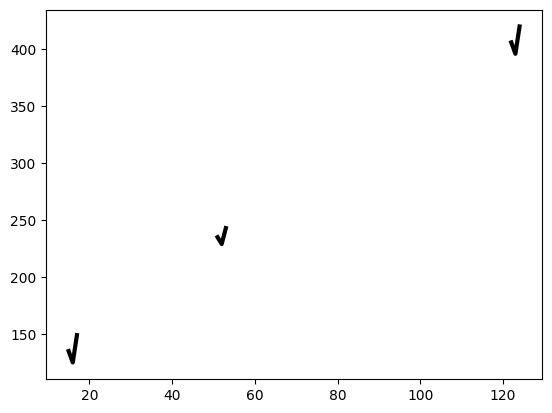

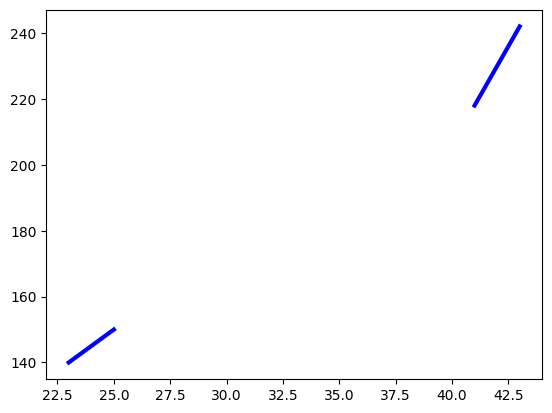

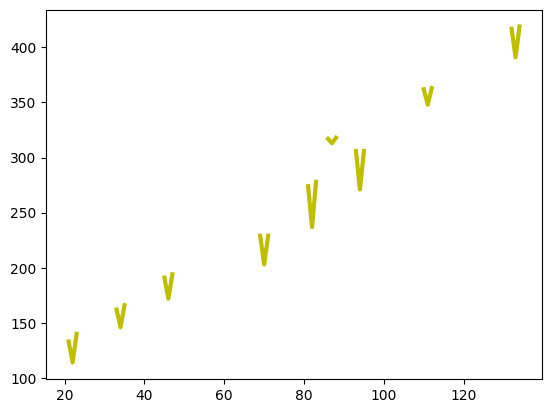

In [8]:
# Rewrite the code above using the correct name variables
for motifs, indices, color in zip(motif_dist, motif_idx, colors):
    for index in indices:
        motif_shape = ts[index:index + w]
        if len(motif_shape) == w:
            plt.plot(range(index, index + w), motif_shape, color=color, lw=3)
    plt.show()
    

### Anomaly Discovery
Parameters  
- mp: matrix profile numpy array
- k: the number of discords to discover
- ex_zone: the number of samples to exclude and set to Inf on either side of a found discord   


Returns a list of indexes represent the discord starting locations. MaxInt indicates there were no more discords that could be found due to too many exclusions or profile being too small. Discord start indices are sorted by highest matrix profile value.

In [9]:
# Calculate z-scores for the matrix profile
z_scores = zscore(mp.tolist())

# Define a threshold (e.g., 3 standard deviations)
threshold = 3

# Find anomalies based on the threshold
anomalies = np.where(np.abs(z_scores) > threshold)[0]


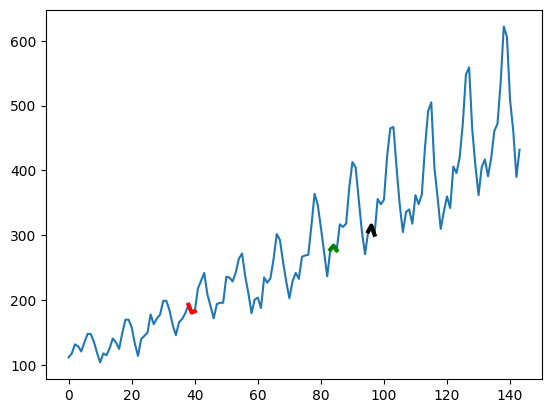

In [10]:
plt.plot(ts)
colors = ['r', 'g', 'k', 'b', 'y'][:len(anomalies)]
for a, c in zip(anomalies, colors):
    a_shape = ts[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()

### Shaplet discovery

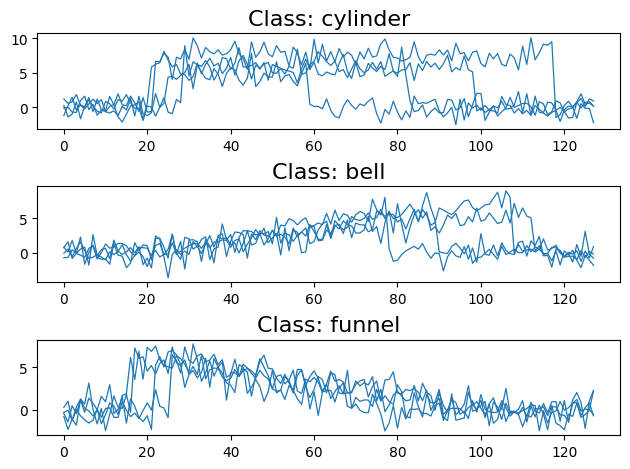

In [11]:
from pyts.datasets import make_cylinder_bell_funnel

X, y = make_cylinder_bell_funnel(n_samples=12, random_state=42)

plt.figure()
for i, classe in enumerate(['cylinder', 'bell', 'funnel']):
    plt.subplot(3, 1, i + 1)
    for x in X[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
plt.show()

In [12]:
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from tslearn.preprocessing import TimeSeriesScalerMinMax

2024-01-02 18:46:34.164907: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [13]:
# Compute number and length of shapelets.
# l: Fraction of the length of time series to be used for base shapelet length
# r: Number of different shapelet lengths to use

# return: Dictionary giving, for each shapelet length, the number of such shapelets to be generated

In [14]:
n_ts, ts_sz = X.shape
n_classes = len(set(y))

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 12
ts_sz 128
n_classes 3
shapelet_sizes {12: 3}


In [15]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1)

/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [16]:
shp_clf.fit(X, y)

Epoch 1/200
1/1 [==============================] - 1s 938ms/step - loss: 3.0438 - categorical_accuracy: 0.4167 - categorical_crossentropy: 3.0122
Epoch 2/200
1/1 [==============================] - 0s 9ms/step - loss: 2.9898 - categorical_accuracy: 0.4167 - categorical_crossentropy: 2.9586
Epoch 3/200
1/1 [==============================] - 0s 7ms/step - loss: 2.9366 - categorical_accuracy: 0.4167 - categorical_crossentropy: 2.9058
Epoch 4/200
1/1 [==============================] - 0s 8ms/step - loss: 2.8842 - categorical_accuracy: 0.4167 - categorical_crossentropy: 2.8539
Epoch 5/200
1/1 [==============================] - 0s 7ms/step - loss: 2.8326 - categorical_accuracy: 0.4167 - categorical_crossentropy: 2.8027
Epoch 6/200
1/1 [==============================] - 0s 8ms/step - loss: 2.7819 - categorical_accuracy: 0.4167 - categorical_crossentropy: 2.7524
Epoch 7/200
1/1 [==============================] - 0s 7ms/step - loss: 2.7320 - categorical_accuracy: 0.4167 - categorical_crossentrop

LearningShapelets(max_iter=200, n_shapelets_per_size={12: 3}, verbose=1,
                  weight_regularizer=0.01)

In [17]:
from sklearn.metrics import accuracy_score
predicted_labels = shp_clf.predict(X)
print("Correct classification rate:", accuracy_score(y, predicted_labels))
predicted_locations = shp_clf.locate(X)

1/1 [==============================] - 0s 170ms/step
Correct classification rate: 0.5
1/1 [==============================] - 0s 105ms/step


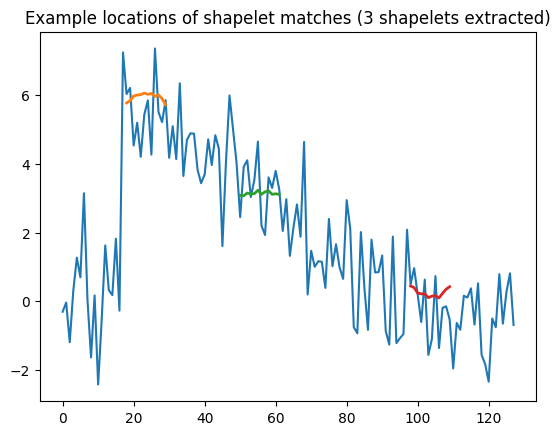

In [18]:
ts_id = 0
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title(f"""Example locations of shapelet matches ({n_shapelets} shapelets extracted)""")

plt.plot(X[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

### Another way of extracting shaplets

The Shapelet Transform algorithm extracts the most discriminative shapelets from a data set of time series. A shapelet is defined as a subset of consecutive points from a time series. Two criteria are made available: mutual information and F-scores.

In [19]:
from pyts.transformation import ShapeletTransform
st = ShapeletTransform(n_shapelets=5, window_sizes=[8])
st.fit(X, y)

ShapeletTransform(n_shapelets=5, window_sizes=[8])

In [20]:
len(st.shapelets_)

5

In [21]:
st.shapelets_

array([[ 3.86768091,  3.44254948,  1.97362051,  4.03209882,  4.69276688,
         2.65224013,  1.44202827,  2.40616013],
       [ 5.26993205,  4.98310642,  1.93153851,  2.67752343,  3.55562448,
         2.71529886,  0.98846153,  2.14169181],
       [ 2.93467989,  2.64084543, -0.74220271,  2.73485874,  1.88747787,
         3.2017051 ,  2.56227483,  2.38649756],
       [ 2.98646757,  3.37317756,  3.56491409,  1.51560696,  2.71553641,
         3.37816335,  1.11274083,  3.4952731 ],
       [ 1.98968297,  4.36556417,  4.12494848,  1.97593873,  1.89793117,
         1.98066962,  1.99844116,  3.38858832]])

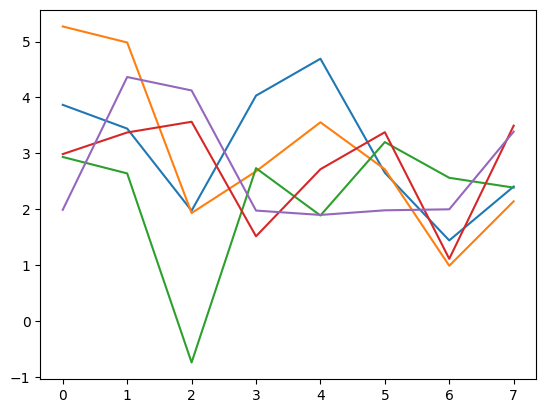

In [22]:
for s in st.shapelets_:
    plt.plot(s)

plt.show()

The indices for the corresponding shapelets in the training set. The first column consists of the indices of the samples. The second column consists of the starting indices (included) of the shapelets. The third column consists of the ending indices (excluded) of the shapelets.

In [23]:
st.indices_

array([[11, 53, 61],
       [ 8, 42, 50],
       [ 9, 42, 50],
       [ 3, 70, 78],
       [11, 63, 71]])

In [24]:
st.scores_

array([0.72282047, 0.73869348, 0.75635221, 0.78654401, 0.80241703])

### Shaplet + classification 


In [25]:
from pyts.classification import LearningShapelets
shp_clf = LearningShapelets(random_state=42, tol=0.01)

In [26]:
shp_clf.fit(X, y)

LearningShapelets(random_state=42, tol=0.01)

In [27]:
shp_clf.coef_.shape

(3, 78)

In [28]:
# Select three shapelets
sel_shapelets = np.asarray([shp_clf.shapelets_[0, 0], 
                        shp_clf.shapelets_[0, 1], 
                        shp_clf.shapelets_[0, 2]])

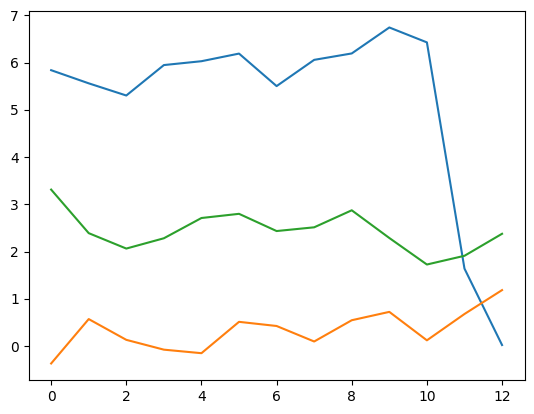

In [29]:
plt.plot(sel_shapelets[0])
plt.plot(sel_shapelets[1])
plt.plot(sel_shapelets[2])

plt.show()